In [47]:
# Import necessary libraries for preprocessing
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, KFold
from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_percentage_error, root_mean_squared_error

'''The point of this section is to A) import the dataset, B) drop unecessary columns (assuming you need to), C) rename columns (if you want),
and then D) adjust data types. This file specifically deals with the distance values extracted in meters, which were "how far away, in meters, the nearest POI was".'''

#Load the dataset. Atlanta_Nearest_Distances.csv is the dataset being used. It is essentially a placeholder. 
#It is also assuming this is a LOCAL file that was downloaded directly to the computer, hence the location. This can be replaced with anything, like a git location. 
Atlanta_Distance = pd.read_csv('~/Documents/NYCDSA/Capstone/Nearest_Distances_Atlanta/Atlanta_Nearest_Distances.csv')

#Combine redundant columns. The two baths columns are addressing the same overall feature, they can be combined into "total baths", like "total bedrooms".
#Half baths is multiplied by .5 of a value because it is "half of a full bath"
Atlanta_Distance['Total Bathrooms'] = Atlanta_Distance['number_of_full_baths'] + (Atlanta_Distance['number_of_half_baths']*0.5)

#Drop any columns you aren't analyzing. This was taken from a baseline, where columns to be included were decided later. 
Atlanta_Distance = Atlanta_Distance.drop(columns=['latitude',
                                                  'longitude', 'lot_size_in_acres', 'number_of_full_baths', 'number_of_half_baths',
                                                  	'has_pool', 'has_garage', 'number_of_garage_spaces', 'number_of_stories', 'lot_size_in_square_feet',
                                                 'Supercenter_POI', 'Convenience_POI', 'Supermarket_POI', 'Wholesale_POI', 'Variety_Store_POI', 'story_indicator'])

#Rename columns for clarity. 
Atlanta_Distance = Atlanta_Distance.rename(columns={'Distance_SM': 'Supermarket', 'Distance_C': 'Convenience',
'Distance_WS': 'Wholesale', 'Distance_VS': 'Variety Store', 'Distance_SC': 'Supercenter', 'number_of_bedrooms': 'Total Bedrooms', 'living_area_square_feet': 'Living Area(SQF)',
                                                'year_built': 'Year Built'})

#"Year built" is read as a float OR as a string, it should be read as an integer. For numerical analysis, use int or float if there are missing values, which "year built" has.
Atlanta_Distance['Year Built'] = Atlanta_Distance['Year Built'].astype('Int64')

#We want to group by the street_address because Excel does not order duplicates the same way as Python. So, if this method was done in a different notebook without grouping, the ordering might accidentally be different, causing a different result because of the NAN values.
Atlanta_Distance = Atlanta_Distance.groupby(["street_address"]).max().reset_index(drop = False)

Atlanta_Distance

,street_address,current_listing_price,listing_date,Year Built,Total Bedrooms,Living Area(SQF),Wholesale,Variety Store,Supermarket,Supercenter,Convenience,Total Bathrooms
0,0 ivy MNR DR NW 0,2865,3/12/2024,2002,4,3259.0,10917.45,6405.99,1654.08,2539.28,2715.74,2.5
1,1 10 buena VIS CIR SE,2200,3/2/2024,<NA>,3,1993.0,32739.68,405.11,3065.55,492.63,1407.26,2.0
2,1 1088 coldwater DR,2000,2/15/2024,<NA>,3,1910.0,29267.11,4738.04,3780.13,25413.80,3213.19,2.0
3,1 1130 willivee DR,1995,3/17/2024,<NA>,3,1134.0,9020.53,4356.55,2320.59,7857.71,2385.60,1.0
4,1 1307 idlewood CT,2800,3/3/2024,<NA>,4,2532.0,14750.79,6721.22,5625.35,11676.91,14263.22,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
19213,procurement only - 66 4th ST,1600,3/9/2023,<NA>,3,1367.0,47285.12,6409.21,2097.35,19852.16,4983.93,2.0
19214,r2188 executive DR,2199,3/4/2024,<NA>,3,1696.0,2009.36,6142.54,888.22,4864.86,1477.04,2.5
19215,r3339 woodward down,2380,3/16/2024,2015,3,1944.0,1507.23,714.63,1158.08,1359.41,3952.51,3.5
19216,singleunit 216 greensprings DR,1900,3/4/2024,<NA>,4,1204.0,40632.51,1402.52,8779.81,10787.35,1242.13,2.0


In [48]:
'''We now want to create a pipeline for the dataset, focusing on the numeric features. We begin by selecting just the numeric features, applying a scaler transformer,
and then merging that into a preprocessor'''


# Exclude 'current_listing_price' from features, since this is your target. This will also automatically be excluding street_address, a categorical variable, as that was just being used for grouping.
numeric_features = Atlanta_Distance.select_dtypes(include=['int64', 'float64']).drop(columns=['current_listing_price']).columns

# Pipeline for numeric features: Impute missing values using mean (you may also do median), and then use a scaler for the numeric values. 
numeric_transformer = Pipeline(steps=[
    ('impute_mean', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combined preprocessor for numeric. The preprocessor applies the transformer (filling in the means and scaling the data) to the numeric features. This prevents data leakage
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
])

#Apply preprocessor to original data (this isn't really necessary for this model, but can be useful for others like the MLR) 
transformed_data = preprocessor.fit_transform(Atlanta_Distance)

In [49]:
# Create a list from the numeric features to check if columns were selected correctly.
all_feature_names = list(numeric_features)
all_feature_names

['Year Built',
 'Total Bedrooms',
 'Living Area(SQF)',
 'Wholesale',
 'Variety Store',
 'Supermarket',
 'Supercenter',
 'Convenience',
 'Total Bathrooms']

In [50]:
#Create a dataframe from the applied preprocessor with the list to see the results. This is "technically" not necessary, only if you need to see the data itself.
transformed_df = pd.DataFrame(transformed_data, columns=all_feature_names)
transformed_df

,Year Built,Total Bedrooms,Living Area(SQF),Wholesale,Variety Store,Supermarket,Supercenter,Convenience,Total Bathrooms
0,5.068264e-01,0.670187,1.319220,-0.637664,0.553332,-0.544204,-0.855180,-0.545599,0.189453
1,1.073134e-14,-0.440415,0.101174,1.485733,-1.143762,-0.090871,-1.211535,-0.962407,-0.465279
2,1.073134e-14,-0.440415,0.021318,1.147837,0.081623,0.138637,3.127638,-0.387139,-0.465279
3,1.073134e-14,-0.440415,-0.725288,-0.822242,-0.026265,-0.330136,0.070843,-0.650763,-1.774741
4,1.073134e-14,0.670187,0.619757,-0.264663,0.642481,0.731281,0.735827,3.132781,-0.465279
...,...,...,...,...,...,...,...,...,...
19213,1.073134e-14,-0.440415,-0.501114,2.901067,0.554242,-0.401836,2.159268,0.176920,-0.465279
19214,1.073134e-14,-0.440415,-0.184576,-1.504459,0.478826,-0.790182,-0.450260,-0.940179,0.189453
19215,1.120386e+00,-0.440415,0.054030,-1.553319,-1.056228,-0.703509,-1.060615,-0.151633,1.498915
19216,1.073134e-14,0.670187,-0.657940,2.253740,-0.861687,1.744424,0.580940,-1.015008,-0.465279


In [51]:
'''Next is to create the initial model. This model calls for a train-test-validation split, also called a three-way split. First, the model needs to be defined and
put into the pipeline. Then, the split needs to be defined. This is explained in detail in the code. After this is done, the pipeline should be fit on the training set.
A linear regression is a simple model that predicts a target variable by finding the linear relationship between the target and one or more input features.'''

# Define the full model pipeline including the preprocessor. You can "recall" parts of the pipeline using their string names. 
#For example, if you wanted to just use the model, you'd use 'regressor__' before loading. 
model = LinearRegression()

# Initialize the linear regression model and create a new pipeline that includes the model and preprocessor. 
mlr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model),
])

#1. Split the dataset into a train set and a test set.
#2. Split the training data further into a training set and a validation set.
#3. Use the validation set for tuning, then assess performance on the test set.

X = Atlanta_Distance.drop(columns='current_listing_price') #This can also be replaced with "transformed_df", as, again, they do the same thing. 
y = Atlanta_Distance['current_listing_price'] #transformed_df does not have the target, as it's not supposed to be transformed, so it can't be replaced here.
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #This splits your data into 80% (X_train_val) and 20% (X_test)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42) #X_train_val data is further split into 60% train set (X_train) and 20% validation (X_val)
#Note: the test_size=0.25 is used to split the remaining training and validation set into 75% training and 25% validation (75% of 80% = 60%)

#Test Set (X_test): This set is a held-out portion of the data that the model has never seen during training or tuning, making it the best indicator of the model's generalization performance. The test score tells you how well the model is likely to perform on truly unseen data, which is typically the main goal.

#Validation Set (X_val): The validation set is primarily used during model selection and hyperparameter tuning. It gives a good intermediate measure of model performance, but since it has influenced model tuning, it can no longer be considered a truly unbiased assessment of generalization.

#Combined Train-Validation Set (X_train_val): This set is used for final training once the best model has been selected. While scores on this set give an idea of how well the model fits on a larger amount of data, they do not represent true generalization performance, as the data has been used for model tuning and training.

#Training Set (X_train): The training set score can help diagnose underfitting or overfitting during development, but it isn’t relevant as a final evaluation metric because it doesn’t measure how well the model generalizes.

#Convert the target split data into their logarithmic forms, in order to make it easier to analyze, visualize, and interpret the results.
y_train_log = np.log1p(y_train)  
y_val_log = np.log1p(y_val)
y_test_log = np.log1p(y_test)
y_combined_log = np.log1p(y_train_val)

# Fit the model on the training data
mlr_pipeline.fit(X_train, y_train_log) #The pipeline is fit on the training data and evaluated on the validation set (X_val)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Year Built', 'Total Bedrooms', 'Living Area(SQF)', 'Wholesale',
       'Variety Store', 'Supermarket', 'Supercenter', 'Convenience',
       'Total Bathrooms'],
      dtype='object'))])),
                ('regressor', LinearRegression())])

In [52]:
'''We then "can" calculate the R^2, Mean Squared Error, Root Mean Squared Error, and Mean Absolute Percentage Error for the default sets.
However, these values are typically lower because they aren't tuned.'''

#The goal is to have the test score be as close to the train-val score as possible. This score can be used to compare your future model against, but, 
#unless specified, only a tuned model would be preferred since that is supposed to have a higher score

#MLR models cannot be tuned. Therefore, we'll try using a K-fold to shuffle it instead, taking the average score.
#score() : is just comparing the error/residual in between the actual values and the predicted values.
#r2_score() :- it is the value which specifies the amount of the residual across the whole dataset. The r2 score is more robust and quite often used accuracy matrix.

kf = KFold(n_splits=10, shuffle=True, random_state=42)
# Define the metrics to be considered
metrics = ['r2', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error']

#Create the cross-validation models. It starts with an estimator, the x-values, the target, the scoring method (we're using multiple scoring), and then the folds. 
cv_results_val = cross_validate(
    mlr_pipeline, X_val, y_val_log, scoring=metrics, cv=kf, n_jobs=-1
)
cv_results_test = cross_validate(
    mlr_pipeline, X_test, y_test_log, scoring=metrics, cv=kf, n_jobs=-1
)
cv_results_combined = cross_validate(
    mlr_pipeline, X_train_val, y_combined_log, scoring=metrics, cv=kf, n_jobs=-1
)


In [53]:
# Function to calculate mean of scores and adjust negative scores for MSE, MAPE, and RMSE
def get_mean_scores_with_labels(cv_results, metrics, rename_map):
    """
    Calculate the mean scores for specified metrics from cross-validation results.

    This function extracts the scores for each specified metric from the
    cross-validation results (`cv_results`), computes their mean, and adjusts
    the sign of negative metrics (e.g., neg_mean_squared_error, neg_mean_absolute_percentage_error,
    neg_root_mean_squared_error) by converting them to positive values for interpretability.

    Parameters:
    ----------
    cv_results : dict
        Cross-validation results.
    
    metrics : list of str
        List of metrics to calculate the mean for.

     rename_map (dict): A mapping of metric names to their desired labels.

    Returns:
    -------
    mean_scores : list
        A dictionary where the keys are the metric names (as provided in the `metrics` list)
        and the values are the mean scores for those metrics, averaged across all folds.
        For negative metrics, the values are converted to positive.

    Notes:
    ------
    - Negative metrics are automatically converted to positive values for consistency and readability.
    - This function is particularly useful for summarizing cross-validation results into a single
      set of averaged scores for multiple metrics.

    """
    mean_scores = []
    for metric in metrics:
        mean_score = np.mean(cv_results[f'test_{metric}'])
        # Adjust negative values for metrics starting with "neg"
        if 'neg' in metric:
            mean_score = -mean_score  # Convert to positive
        # Add descriptive label
        metric_label = rename_map.get(metric, metric).upper()
        mean_scores.append(f"{metric_label}: {mean_score:.4f}")
    return mean_scores

rename_map = {
    "r2": "R2",
    "neg_mean_squared_error": "MSE",
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_percentage_error": "MAPE",
}

# Get mean scores with labels for each set
cv_results_val_mean = get_mean_scores_with_labels(cv_results_val, metrics, rename_map)
cv_results_test_mean = get_mean_scores_with_labels(cv_results_test, metrics, rename_map)
cv_results_combined_mean = get_mean_scores_with_labels(cv_results_combined, metrics, rename_map)

print("Validation Distance MLR Scores:", cv_results_val_mean)
print("Test Distance MLR Scores:", cv_results_test_mean)
print("Train-Val Distance MLR Scores:", cv_results_combined_mean)

Validation Distance MLR Scores: ['R2: 0.3928', 'MSE: 0.0711', 'RMSE: 0.2656', 'MAPE: 0.0234']
Test Distance MLR Scores: ['R2: 0.3498', 'MSE: 0.0717', 'RMSE: 0.2662', 'MAPE: 0.0235']
Train-Val Distance MLR Scores: ['R2: 0.3394', 'MSE: 0.0723', 'RMSE: 0.2682', 'MAPE: 0.0234']


In [54]:
'''This next section will be used in a different notebook in order to conduct statistical tests between the various models. Essentially, the goal is to 
extract the individual fold scores and then export them as a pickle file'''

# Extract only the relevant metrics from cv_results_test (exclude 'fit_time' and 'score_time')
cv_results_df = pd.DataFrame(cv_results_test)

# List of the metrics (you can adjust this to your actual metrics)
# Assuming `metrics` contains names like 'r2', 'neg_mean_squared_error', etc.
metrics = ['test_r2', 'test_neg_mean_squared_error', 
                   'test_neg_root_mean_squared_error', 'test_neg_mean_absolute_percentage_error']

# Create the DataFrame where rows are folds and columns are the metrics
distance_MLR_scores = cv_results_df[metrics]

# Rename the columns to more user-friendly names
distance_MLR_scores.columns = ['R²', 'MSE', 'RMSE', 'MAPE']

# The rows are the folds (so the index will be automatically set to the fold numbers)
distance_MLR_scores.index = [f'Fold {i+1}' for i in range(10)]

# Print the result
print(distance_MLR_scores)
distance_MLR_scores.to_pickle("./Scores/distance_MLR_scores.pkl")

               R²       MSE      RMSE      MAPE
Fold 1   0.409310 -0.074109 -0.272231 -0.023683
Fold 2   0.341093 -0.070934 -0.266334 -0.024320
Fold 3   0.382809 -0.061864 -0.248725 -0.022807
Fold 4   0.417757 -0.057615 -0.240032 -0.022694
Fold 5   0.355022 -0.074763 -0.273428 -0.023551
Fold 6   0.440047 -0.071278 -0.266979 -0.024172
Fold 7   0.411507 -0.059606 -0.244143 -0.022442
Fold 8   0.429527 -0.060159 -0.245272 -0.022649
Fold 9  -0.091402 -0.121058 -0.347935 -0.025628
Fold 10  0.402479 -0.066089 -0.257077 -0.022608


In [55]:
# Access the coefficients and intercept of the model within the pipeline
coefficients = mlr_pipeline.named_steps['regressor'].coef_  
intercept = mlr_pipeline.named_steps['regressor'].intercept_

print("Coefficients (MLE):", coefficients)  
print("Intercept (MLE):", intercept)    

Coefficients (MLE): [ 0.0026261   0.05658146  0.06459274  0.01305107  0.01677867 -0.02147766
 -0.04739874 -0.02631827  0.10255632]
Intercept (MLE): 7.660327646788302


In [56]:
# Create a DataFrame with feature names and their corresponding coefficients
coef_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient (MLE)': coefficients
})

# Create a DataFrame for the intercept with a label 'Intercept'
intercept_row = pd.DataFrame({'Feature': ['Intercept'], 'Coefficient (MLE)': [intercept]})

# Combine the feature coefficients with the intercept row
coef_df = pd.concat([coef_df, intercept_row], ignore_index=True)

# Add a new column for the absolute values of the coefficients
coef_df['Absolute Coefficient'] = coef_df['Coefficient (MLE)']  

# Sort the coefficients by absolute value in descending order and drop the temporary column
coef_df = coef_df.sort_values(by='Absolute Coefficient', ascending=False).drop(columns='Absolute Coefficient')

print(coef_df)

            Feature  Coefficient (MLE)
9         Intercept           7.660328
8   Total Bathrooms           0.102556
2  Living Area(SQF)           0.064593
1    Total Bedrooms           0.056581
4     Variety Store           0.016779
3         Wholesale           0.013051
0        Year Built           0.002626
5       Supermarket          -0.021478
7       Convenience          -0.026318
6       Supercenter          -0.047399


In [57]:
'''Although a MLR model cannot be tuned, you can use alternative "naturalization" regression methods to attempt to improve its scores. A Ridge regression is one of these methods.
A ridge regression shifts the coefficients towards zero, but never exactly at zero.'''

#Create new ridge model. A random state can be created to ensure the same results each time the model is ran.
ridge_model = Ridge(alpha = 100, random_state=42)

#We have to make a new pipeline because we have a new model, but the preprocessor is the same
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', ridge_model),
])

#Create a parameter. Ridge usually relies on alpha fluctuations. 
param = {
    'regressor__alpha': [100]
}

#This is very similar to the cross-validation we just did, but gridsearch requires refitting
ridge_search = GridSearchCV(
    estimator=ridge_pipeline,
    param_grid=param,
    scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error'],
    refit='r2', 
    cv=kf,  # Number of cross-validation folds. We'll use the k-folds again
    n_jobs=-1,  # Use all available cores
    verbose=2,
)

# You have to fit both the pipeline and the gridsearch to conduct coefficient testing for a ridge. Gridsearch doesn't have "coef_". 
ridge_search.fit(X_train, y_train_log)
ridge_pipeline.fit(X_train, y_train_log)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Year Built', 'Total Bedrooms', 'Living Area(SQF)', 'Wholesale',
       'Variety Store', 'Supermarket', 'Supercenter', 'Convenience',
       'Total Bathrooms'],
      dtype='object'))])),
                ('regressor', Ridge(alpha=100, random_state=42))])

In [58]:
'''This next section will once again be exported to conduct statistical tests, but it needs to be modified since hyperparamter tuning was used.'''

# Access cv_results_ from the grid search
cv_results = ridge_search.cv_results_

metrics = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error']

# Get the number of folds used in cross-validation
n_folds = kf.get_n_splits()

# Extract fold-wise scores for each metric
fold_scores = {f'Fold {i + 1}': {metric: cv_results[f'split{i}_test_{metric}'][ridge_search.best_index_] for metric in metrics}
               for i in range(n_folds)}

# Convert the scores into a DataFrame
distance_ridge_scores = pd.DataFrame(fold_scores).T

# Rename the columns for clarity
distance_ridge_scores.columns = ['R²', 'MSE', 'MAPE', 'RMSE']

# Display the DataFrame
print("Scores Ridge Distance (Folds as Rows, Metrics as Columns):")
print(distance_ridge_scores)
distance_ridge_scores.to_pickle("./Scores/distance_ridge_scores.pkl")

Scores Ridge Distance (Folds as Rows, Metrics as Columns):
               R²       MSE      MAPE      RMSE
Fold 1   0.019772 -0.104260 -0.023597 -0.322893
Fold 2   0.395566 -0.073196 -0.023799 -0.270548
Fold 3   0.373866 -0.067691 -0.023134 -0.260175
Fold 4   0.344330 -0.060666 -0.021910 -0.246306
Fold 5   0.348165 -0.072168 -0.024041 -0.268641
Fold 6   0.383490 -0.064761 -0.022998 -0.254482
Fold 7   0.332224 -0.065879 -0.022552 -0.256669
Fold 8   0.382540 -0.068606 -0.024294 -0.261927
Fold 9   0.353621 -0.069182 -0.022724 -0.263025
Fold 10  0.321283 -0.076034 -0.024155 -0.275743


In [59]:
#Best_model is technically irrelevant because the this model is already narrowed down by what the best model is.
#However, if you had multiple models searches, like different numbers for esitmators, it'll find which one leads to the best score. 
best_model = ridge_search.best_estimator_

# Best score is the "best mean cross-validation score", based on the training set. Best params was already chosen for us, but it's the parameters that gives the highest scores.
results = ridge_search.cv_results_
print("Best parameters:", ridge_search.best_params_)
print("Best R^2:", ridge_search.best_score_)

Best parameters: {'regressor__alpha': 100}
Best R^2: 0.3254856993694185


In [60]:
def calculate_scores(y_true, y_pred):
    """
    Calculate and return multiple regression evaluation metrics.

    This function computes the R² score, Mean Squared Error (MSE), 
    Mean Absolute Percentage Error (MAPE), and Root Mean Squared Error (RMSE) 
    for a set of true values and predicted values, providing a comprehensive 
    evaluation of model performance.

    Parameters:
    ----------
    y_true : array-like
        The true target values.
    y_pred : array-like
        The predicted target values from the model.

    Returns:
    -------
    tuple
        A tuple containing the following scores:
        - r2 : float : R² score, indicating the proportion of variance explained by the model.
        - mse : float : Mean Squared Error, measuring the average squared difference between 
          the predicted and actual values.
        - mape : float : Mean Absolute Percentage Error, showing the average percentage error.
        - rmse : float : Root Mean Squared Error, providing an interpretable measure of 
          prediction error in the original units of the target variable.
    """
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    return r2, mse, mape, rmse

In [61]:
'''We now want to create a method to calculate the scores for every set.
Using the previous function, we merely use it against each version of "best model" predicted against each set.'''
#You "can" refit the model on the train_val set under the pretense that it will give a better score. This is assuming there isn't egregious overfitting.
#Refitting the model has the least amount of impact on the test score. 
best_model.fit(X_train_val, y_combined_log)

#Applies the function to the val set
y_val_pred_tuned = best_model.predict(X_val)
val_scores = calculate_scores(y_val_log, y_val_pred_tuned)

#Applies the function to the test set
y_test_pred_tuned = best_model.predict(X_test)
test_scores = calculate_scores(y_test_log, y_test_pred_tuned)

#Applies the function to the train-val set
y_combined_pred_tuned = best_model.predict(X_train_val)
combined_scores = calculate_scores(y_combined_log, y_combined_pred_tuned)

print("Tuned Ridge Validation Set Scores:")
print(f"R²: {val_scores[0]:.4f}")
print(f"MSE: {val_scores[1]:.4f}")
print(f"MAPE: {val_scores[2]:.4f}")
print(f"RMSE: {val_scores[3]:.4f}")

print("\nTuned Ridge Test Set Scores:")
print(f"R²: {test_scores[0]:.4f}")
print(f"MSE: {test_scores[1]:.4f}")
print(f"MAPE: {test_scores[2]:.4f}")
print(f"RMSE: {test_scores[3]:.4f}")

print("\nTuned Train-Val Set Scores:")
print(f"R²: {combined_scores[0]:.4f}")
print(f"MSE: {combined_scores[1]:.4f}")
print(f"MAPE: {combined_scores[2]:.4f}")
print(f"RMSE: {combined_scores[3]:.4f}")

Tuned Ridge Validation Set Scores:
R²: 0.3883
MSE: 0.0718
MAPE: 0.0236
RMSE: 0.2679

Tuned Ridge Test Set Scores:
R²: 0.3776
MSE: 0.0688
MAPE: 0.0230
RMSE: 0.2624

Tuned Train-Val Set Scores:
R²: 0.3571
MSE: 0.0706
MAPE: 0.0233
RMSE: 0.2657


In [62]:
coefficients = ridge_pipeline.named_steps['regressor'].coef_
intercept = ridge_pipeline.named_steps['regressor'].intercept_

In [63]:
# Create a DataFrame with feature names and their corresponding coefficients
coef_df_ridge = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient (MLE)': coefficients
})

#Add intercept row
intercept_row = pd.DataFrame({'Feature': ['Intercept'], 'Coefficient (MLE)': [intercept]})
coef_df_ridge = pd.concat([coef_df_ridge, intercept_row], ignore_index=True)

# Sort the coefficients by absolute value in descending order
coef_df_ridge['Absolute Coefficient'] = coef_df_ridge['Coefficient (MLE)']  # Create a new column for absolute values
coef_df_ridge = coef_df_ridge.sort_values(by='Absolute Coefficient', ascending=False).drop(columns='Absolute Coefficient')  # Sort and drop the temporary column

# Display the coefficients with feature names sorted
print(coef_df_ridge)

            Feature  Coefficient (MLE)
9         Intercept           7.660328
8   Total Bathrooms           0.101669
2  Living Area(SQF)           0.064325
1    Total Bedrooms           0.056658
4     Variety Store           0.016231
3         Wholesale           0.012613
0        Year Built           0.002893
5       Supermarket          -0.021338
7       Convenience          -0.025904
6       Supercenter          -0.046720


In [64]:
'''Another method we can use is the Lasso regression. A lasso regression penalizes the absolute values of the model's coefficients. 
Said penalty causes some of the coefficients to shrink to exactly zero. This excludes the least important variables to prevent overfitting. '''

#We have to make a new model and create a new pipeline from that model, as we did with the ridge. The preprocessor is still the same. 
#However, the model has to be adjusted so that it's the same as the parameter because the coefficients will be using the pipeline, which doesn't have an alpha, and not the gridsearch.
#If this is not done, then all coefficients will be zero because of excessive regularization
lasso_model = Lasso(alpha = .001, random_state=42)
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', lasso_model),
])

#Lasso parameters also rely on alpha, like with the ridge. The lasso model favors much smaller alphas than the ridge model. Otherwise you're just going to get a negative score.
param_lasso = {
    'regressor__alpha': [.001]
}

#Essentially the same as the ridge model, except using the new estimator and parameter. 
lasso_search = GridSearchCV(
    estimator=lasso_pipeline,
    param_grid=param_lasso,
    scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error'],
    refit='r2', 
    cv=kf, 
    n_jobs=-1,
    verbose=2,
)

#Fit both the search and the pipeline for the coefficients
lasso_search.fit(X_train_val, y_combined_log)
lasso_pipeline.fit(X_train, y_train_log)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Year Built', 'Total Bedrooms', 'Living Area(SQF)', 'Wholesale',
       'Variety Store', 'Supermarket', 'Supercenter', 'Convenience',
       'Total Bathrooms'],
      dtype='object'))])),
                ('regressor', Lasso(alpha=0.001, random_state=42))])

In [65]:
'''Repeat the process, although lasso is fine having best_index_'''

# Access cv_results_ from the grid search
cv_results = lasso_search.cv_results_

# Extract fold-wise scores for each metric
fold_scores = {f'Fold {i + 1}': {metric: cv_results[f'split{i}_test_{metric}'][lasso_search.best_index_] for metric in metrics}
               for i in range(n_folds)}

# Convert the scores into a DataFrame
distance_lasso_scores = pd.DataFrame(fold_scores).T

# Rename the columns for clarity
distance_lasso_scores.columns = ['R²', 'MSE', 'MAPE', 'RMSE']

# Display the DataFrame
print("Scores Distance (Folds as Rows, Metrics as Columns):")
print(distance_lasso_scores)
distance_lasso_scores.to_pickle("./Scores/distance_lasso_scores.pkl")

Scores Distance (Folds as Rows, Metrics as Columns):
               R²       MSE      MAPE      RMSE
Fold 1   0.377326 -0.084731 -0.025131 -0.291086
Fold 2   0.415356 -0.063256 -0.022684 -0.251507
Fold 3   0.321909 -0.071689 -0.023373 -0.267747
Fold 4   0.064393 -0.099344 -0.023250 -0.315189
Fold 5   0.359656 -0.073587 -0.024227 -0.271270
Fold 6   0.352254 -0.070332 -0.023554 -0.265202
Fold 7   0.366658 -0.064681 -0.023261 -0.254325
Fold 8   0.361548 -0.062889 -0.022520 -0.250776
Fold 9   0.381917 -0.063719 -0.022325 -0.252427
Fold 10  0.394774 -0.069018 -0.023236 -0.262713


In [66]:
#Find results for easier tuning
best_model_lasso = lasso_search.best_estimator_
results_lasso = lasso_search.cv_results_
print("Best parameters:", lasso_search.best_params_)
print("Best R^2:", lasso_search.best_score_)

Best parameters: {'regressor__alpha': 0.001}
Best R^2: 0.3395790520979821


In [67]:
#Refit the model. Although it doesn't change much. 
best_model_lasso.fit(X_train_val, y_combined_log)

y_val_pred_tuned_lasso = best_model_lasso.predict(X_val)
val_scores_lasso = calculate_scores(y_val_log, y_val_pred_tuned_lasso)

y_test_pred_tuned_lasso = best_model_lasso.predict(X_test)
test_scores_lasso = calculate_scores(y_test_log, y_test_pred_tuned_lasso)

y_combined_pred_tuned_lasso = best_model_lasso.predict(X_train_val)
combined_scores_lasso = calculate_scores(y_combined_log, y_combined_pred_tuned_lasso)

print("Tuned Lasso Validation Set Scores:")
print(f"R²: {val_scores_lasso[0]:.4f}")
print(f"MSE: {val_scores_lasso[1]:.4f}")
print(f"MAPE: {val_scores_lasso[2]:.4f}")
print(f"RMSE: {val_scores_lasso[3]:.4f}")

print("\nTuned Lasso Test Set Scores:")
print(f"R²: {test_scores_lasso[0]:.4f}")
print(f"MSE: {test_scores_lasso[1]:.4f}")
print(f"MAPE: {test_scores_lasso[2]:.4f}")
print(f"RMSE: {test_scores_lasso[3]:.4f}")

print("\nTuned Lasso Train-Val Set Scores:")
print(f"R²: {combined_scores_lasso[0]:.4f}")
print(f"MSE: {combined_scores_lasso[1]:.4f}")
print(f"MAPE: {combined_scores_lasso[2]:.4f}")
print(f"RMSE: {combined_scores_lasso[3]:.4f}")

Tuned Lasso Validation Set Scores:
R²: 0.3881
MSE: 0.0718
MAPE: 0.0236
RMSE: 0.2680

Tuned Lasso Test Set Scores:
R²: 0.3778
MSE: 0.0688
MAPE: 0.0230
RMSE: 0.2624

Tuned Lasso Train-Val Set Scores:
R²: 0.3570
MSE: 0.0706
MAPE: 0.0233
RMSE: 0.2658


In [68]:
coefficients = lasso_pipeline.named_steps['regressor'].coef_
intercept = lasso_pipeline.named_steps['regressor'].intercept_

In [69]:
#The lasso model will, eventually, shrink all coefficients to zero. That's all this is telling us. 
coef_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient (MLE)': coefficients
})
intercept_row = pd.DataFrame({'Feature': ['Intercept'], 'Coefficient (MLE)': [intercept]})
coef_df = pd.concat([coef_df, intercept_row], ignore_index=True)

coef_df['Absolute Coefficient'] = coef_df['Coefficient (MLE)']  # Create a new column for absolute values
coef_df = coef_df.sort_values(by='Absolute Coefficient', ascending=False).drop(columns='Absolute Coefficient')  # Sort and drop the temporary column

# Display the coefficients with feature names sorted
print(coef_df)

            Feature  Coefficient (MLE)
9         Intercept           7.660328
8   Total Bathrooms           0.102427
2  Living Area(SQF)           0.064082
1    Total Bedrooms           0.056013
4     Variety Store           0.013907
3         Wholesale           0.010943
0        Year Built           0.001835
5       Supermarket          -0.019910
7       Convenience          -0.024251
6       Supercenter          -0.045068


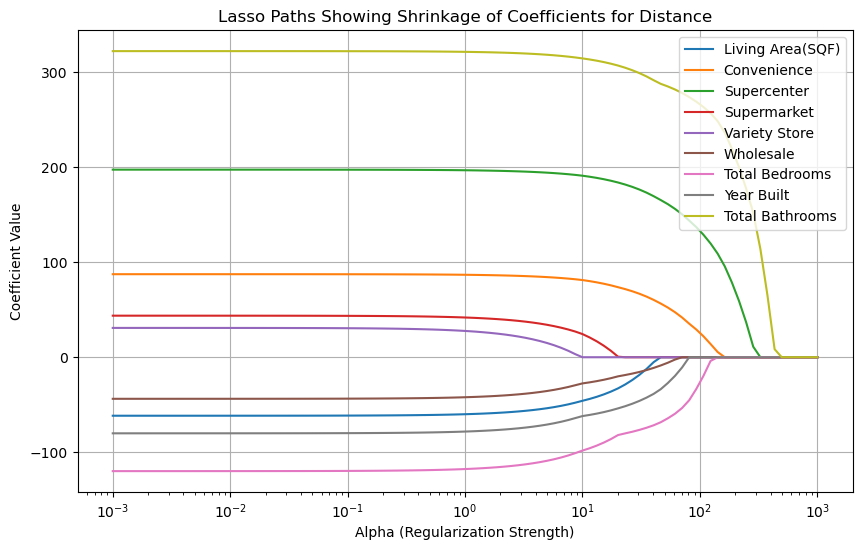

In [70]:
"""
Plots the Lasso regularization path for a range of alpha values.

This graph demonstrates the effect of Lasso regression's regularization strength (\(\alpha\)) on the coefficients 
of features in a dataset. Lasso adds an \(L1\)-regularization term, which can shrink some coefficients to zero, 
effectively performing feature selection.

Key Features of the Plot:
- **X-axis (Alpha)**: The regularization strength (\(\alpha\)) plotted on a logarithmic scale, ranging from 0.001 (weak regularization) to 100 (strong regularization).
- **Y-axis (Coefficient Value)**: The values of the coefficients for each feature as the regularization strength changes.
- **Lines**: Each line represents the regularization path of a specific feature, showing how its coefficient changes (shrinks or is eliminated) as \(\alpha\) increases.
- **Interpretation**: 
  - For small \(\alpha\) values, regularization is weak, and the coefficients are close to their ordinary least squares values.
  - As \(\alpha\) increases, the coefficients shrink, with less important features eventually being reduced to zero.
  
Steps in the Code:
1. Define a range of \(\alpha\) values using a logarithmic scale.
2. Scale the features to ensure fair regularization treatment across features.
3. Fit Lasso regression models for each \(\alpha\) and store the coefficients.
4. Plot the regularization paths for all features to visualize how their coefficients change.

Output:
- A plot displaying the shrinkage and elimination of feature coefficients across different \(\alpha\) values.
"""
# Define the range of alpha values (regularization strength)

alphas = np.logspace(-3, 3, 100)  # Try values from 0.001 to 100 on a log scale

# Scale the features if needed
scaler = StandardScaler()
X_scaled = transformed_df

# Initialize an empty array to store coefficients
coefs = []

# For each alpha, fit Lasso and store the coefficients
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_scaled, y)
    coefs.append(lasso.coef_)

# Convert coefficients list to a numpy array for plotting
coefs = np.array(coefs)

# Plot the regularization path
plt.figure(figsize=(10, 6))

# Plot each feature’s coefficient path
for i, feature in enumerate(['Living Area(SQF)', 'Convenience', 'Supercenter', 'Supermarket', 'Variety Store', 'Wholesale', 'Total Bedrooms', 'Year Built', 'Total Bathrooms']):
    plt.plot(alphas, coefs[:, i], label=feature)

# Set up plot details
plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("Coefficient Value")
plt.title("Lasso Paths Showing Shrinkage of Coefficients for Distance")
plt.legend()
plt.xscale("log")  # Use a log scale for alpha
plt.grid(True)
#Save graph (folder_path + file_name)
plt.savefig("./Graphs/" + 'distance_lasso_regularization.png')
plt.show()

In [71]:
"""
The following is an attempt to extract the scores from the baseline model. A baseline is all independent variables except any variables that were added 
as part of the project. In this case, that would be anything related to the grocery stores. "b" literally represents baseline.
The outline for everything is otherwise identical. 
"""

#Drop distance columns
Atlanta_Baseline = Atlanta_Distance.drop(columns=['Wholesale','Variety Store','Supermarket','Supercenter','Convenience'])
#We don't have to do anything additional with the preprocessor since that was already done for us in the distance model. The only thing different is the number of features, hence the new numeric variable.
numeric_features_b = Atlanta_Baseline.select_dtypes(include=['int64', 'float64']).drop(columns=['current_listing_price']).columns
preprocessor_b = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_b)
])

transformed_data_b = preprocessor_b.fit_transform(Atlanta_Baseline)
all_feature_names_b = list(numeric_features_b)
transformed_df_b = pd.DataFrame(transformed_data_b, columns=all_feature_names_b)
transformed_df_b

,Year Built,Total Bedrooms,Living Area(SQF),Total Bathrooms
0,5.068264e-01,0.670187,1.319220,0.189453
1,1.073134e-14,-0.440415,0.101174,-0.465279
2,1.073134e-14,-0.440415,0.021318,-0.465279
3,1.073134e-14,-0.440415,-0.725288,-1.774741
4,1.073134e-14,0.670187,0.619757,-0.465279
...,...,...,...,...
19213,1.073134e-14,-0.440415,-0.501114,-0.465279
19214,1.073134e-14,-0.440415,-0.184576,0.189453
19215,1.120386e+00,-0.440415,0.054030,1.498915
19216,1.073134e-14,0.670187,-0.657940,-0.465279


In [72]:
#We have to apply a new preprocessor to the pipeline, therefore a new pipeline has to be created. 
mlr_pipeline_b = Pipeline(steps=[
    ('preprocessor', preprocessor_b),
    ('regressor', model),
])

#Everything has to have a new variable and be refitted because it's now being applied to a "new" set of features. 
X_b = Atlanta_Baseline.drop(columns='current_listing_price')
y_b = Atlanta_Baseline['current_listing_price']
X_train_val_b, X_test_b, y_train_val_b, y_test_b = train_test_split(X_b, y_b, test_size=0.2, random_state=42)
X_train_b, X_val_b, y_train_b, y_val_b = train_test_split(X_train_val_b, y_train_val_b, test_size=0.25, random_state=42)

y_train_log_b = np.log1p(y_train_b)  
y_val_log_b = np.log1p(y_val_b)
y_test_log_b = np.log1p(y_test_b)
y_combined_log_b = np.log1p(y_train_val_b)

# Fit the model on the training data
mlr_pipeline_b.fit(X_train_b, y_train_log_b)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Year Built', 'Total Bedrooms', 'Living Area(SQF)', 'Total Bathrooms'], dtype='object'))])),
                ('regressor', LinearRegression())])

In [73]:
#Metrics is the same since it's just a multiple scoring method 
cv_results_val_b = cross_validate(
    mlr_pipeline_b, X_val_b, y_val_log_b, scoring=metrics, cv=kf, n_jobs=-1
)
cv_results_test_b = cross_validate(
    mlr_pipeline_b, X_test_b, y_test_log_b, scoring=metrics, cv=kf, n_jobs=-1
)
cv_results_combined_b = cross_validate(
    mlr_pipeline_b, X_train_val_b, y_combined_log_b, scoring=metrics, cv=kf, n_jobs=-1
)

#The function and renamed metrics are also already done for us, we just have to change the variables. 
cv_results_val_mean_b = get_mean_scores_with_labels(cv_results_val_b, metrics, rename_map)
cv_results_test_mean_b = get_mean_scores_with_labels(cv_results_test_b, metrics, rename_map)
cv_results_combined_mean_b = get_mean_scores_with_labels(cv_results_combined_b, metrics, rename_map)

print("Validation Baseline Scores:", cv_results_val_mean_b)
print("Test Baseline Scores:", cv_results_test_mean_b)
print("Train-Val Baseline Scores:", cv_results_combined_mean_b)

Validation Baseline Scores: ['R2: 0.3675', 'MSE: 0.0740', 'MAPE: 0.0239', 'RMSE: 0.2711']
Test Baseline Scores: ['R2: 0.3223', 'MSE: 0.0749', 'MAPE: 0.0242', 'RMSE: 0.2719']
Train-Val Baseline Scores: ['R2: 0.3102', 'MSE: 0.0755', 'MAPE: 0.0239', 'RMSE: 0.2741']


In [74]:
# Extract only the relevant metrics from cv_results_test (exclude 'fit_time' and 'score_time')
cv_results_df = pd.DataFrame(cv_results_test_b)

# List of the metrics (you can adjust this to your actual metrics)
# Assuming `metrics` contains names like 'r2', 'neg_mean_squared_error', etc.
metrics = ['test_r2', 'test_neg_mean_squared_error', 
                   'test_neg_root_mean_squared_error', 'test_neg_mean_absolute_percentage_error']

# Create the DataFrame where rows are folds and columns are the metrics
baseline_MLR_scores = cv_results_df[metrics]

# Rename the columns to more user-friendly names
baseline_MLR_scores.columns = ['R²', 'MSE', 'RMSE', 'MAPE']

# The rows are the folds (so the index will be automatically set to the fold numbers)
baseline_MLR_scores.index = [f'Fold {i+1}' for i in range(10)]

# Print the result
print(baseline_MLR_scores)
baseline_MLR_scores.to_pickle("./Scores/baseline_MLR_scores.pkl")

               R²       MSE      RMSE      MAPE
Fold 1   0.368223 -0.079264 -0.281539 -0.024550
Fold 2   0.306996 -0.074604 -0.273138 -0.025211
Fold 3   0.360481 -0.064102 -0.253184 -0.023161
Fold 4   0.417163 -0.057674 -0.240154 -0.023125
Fold 5   0.329089 -0.077769 -0.278871 -0.024511
Fold 6   0.412505 -0.074783 -0.273466 -0.024923
Fold 7   0.396700 -0.061106 -0.247196 -0.022867
Fold 8   0.400516 -0.063218 -0.251432 -0.023161
Fold 9  -0.130406 -0.125385 -0.354097 -0.026725
Fold 10  0.361479 -0.070623 -0.265751 -0.023270


In [75]:
#For comparison, the Distance MLR were superior. 
print("Validation Distance MLR Scores:", cv_results_val_mean)
print("Test Distance MLR Scores:", cv_results_test_mean)
print("Train-Val Distance MLR Scores:", cv_results_combined_mean)

Validation Distance MLR Scores: ['R2: 0.3928', 'MSE: 0.0711', 'RMSE: 0.2656', 'MAPE: 0.0234']
Test Distance MLR Scores: ['R2: 0.3498', 'MSE: 0.0717', 'RMSE: 0.2662', 'MAPE: 0.0235']
Train-Val Distance MLR Scores: ['R2: 0.3394', 'MSE: 0.0723', 'RMSE: 0.2682', 'MAPE: 0.0234']


In [76]:
coefficients_b = mlr_pipeline_b.named_steps['regressor'].coef_
intercept_b = mlr_pipeline_b.named_steps['regressor'].intercept_

# Display the coefficients
print("Coefficients (MLE):", coefficients_b)
coef_df_b = pd.DataFrame({
    'Feature': all_feature_names_b,
    'Coefficient (MLE)': coefficients_b
})
intercept_row_b = pd.DataFrame({'Feature': ['Intercept'], 'Coefficient (MLE)': [intercept_b]})
coef_df_b = pd.concat([coef_df_b, intercept_row_b], ignore_index=True)

coef_df_b['Absolute Coefficient'] = coef_df_b['Coefficient (MLE)']  # Create a new column for absolute values
coef_df_b = coef_df_b.sort_values(by='Absolute Coefficient', ascending=False).drop(columns='Absolute Coefficient')  # Sort and drop the temporary column

# Display the coefficients with feature names sorted
print(coef_df_b)
print("Intercept (MLE):", intercept_b)

Coefficients (MLE): [-0.00408265  0.05136535  0.06479713  0.10895843]
            Feature  Coefficient (MLE)
4         Intercept           7.660328
3   Total Bathrooms           0.108958
2  Living Area(SQF)           0.064797
1    Total Bedrooms           0.051365
0        Year Built          -0.004083
Intercept (MLE): 7.660327646788302


In [77]:
#The parameters are the same as the distance model, but just to be careful you should make another model. 
ridge_model_b = Ridge(alpha = 100, random_state=42)
param_ridge_b = {
    'regressor__alpha': [100]
}
ridge_pipeline_b = Pipeline(steps=[
    ('preprocessor', preprocessor_b),
    ('regressor', ridge_model_b),
])
ridge_search_b = GridSearchCV(
    estimator=ridge_pipeline_b,
    param_grid=param_ridge_b,
    scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error'],
    refit='r2', 
    cv= kf, 
    n_jobs=-1, 
    verbose=2,
)

# Fit GridSearchCV
ridge_search_b.fit(X_train_b, y_train_log_b)
ridge_pipeline_b.fit(X_train_b, y_train_log_b)

best_model_b = ridge_search_b.best_estimator_
results_b = ridge_search_b.cv_results_
print("Best parameters:", ridge_search_b.best_params_)
print("Best R^2:", ridge_search_b.best_score_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best parameters: {'regressor__alpha': 100}
Best R^2: 0.29577039536932126


In [78]:
# Access cv_results_ from the grid search
cv_results = ridge_search_b.cv_results_

metrics = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error']

# Get the number of folds used in cross-validation
n_folds = kf.get_n_splits()

# Extract fold-wise scores for each metric
fold_scores = {f'Fold {i + 1}': {metric: cv_results[f'split{i}_test_{metric}'][ridge_search_b.best_index_] for metric in metrics}
               for i in range(n_folds)}

# Convert the scores into a DataFrame
baseline_ridge_scores = pd.DataFrame(fold_scores).T

# Rename the columns for clarity
baseline_ridge_scores.columns = ['R²', 'MSE', 'MAPE', 'RMSE']

# Display the DataFrame
print("Scores Ridge Distance (Folds as Rows, Metrics as Columns):")
print(baseline_ridge_scores)
baseline_ridge_scores.to_pickle("./Scores/baseline_ridge_scores.pkl")

Scores Ridge Distance (Folds as Rows, Metrics as Columns):
               R²       MSE      MAPE      RMSE
Fold 1  -0.011881 -0.107626 -0.024430 -0.328065
Fold 2   0.365690 -0.076814 -0.024489 -0.277154
Fold 3   0.342211 -0.071113 -0.023630 -0.266671
Fold 4   0.322596 -0.062677 -0.022249 -0.250355
Fold 5   0.317011 -0.075617 -0.024570 -0.274985
Fold 6   0.351301 -0.068142 -0.023589 -0.261040
Fold 7   0.304111 -0.068652 -0.023163 -0.262016
Fold 8   0.350729 -0.072140 -0.024859 -0.268589
Fold 9   0.328731 -0.071846 -0.023367 -0.268041
Fold 10  0.287205 -0.079852 -0.024730 -0.282581


In [79]:
best_model_b.fit(X_train_val_b, y_combined_log_b)

y_val_pred_tuned_b = best_model_b.predict(X_val_b)
val_scores_b = calculate_scores(y_val_log_b, y_val_pred_tuned_b)

y_test_pred_tuned_b = best_model_b.predict(X_test_b)
test_scores_b = calculate_scores(y_test_log_b, y_test_pred_tuned_b)

y_combined_pred_tuned_b = best_model_b.predict(X_train_val_b)
combined_scores_b = calculate_scores(y_combined_log_b, y_combined_pred_tuned_b)

print("Tuned Validation Set Scores:")
print(f"R²: {val_scores_b[0]:.4f}")
print(f"MSE: {val_scores_b[1]:.4f}")
print(f"MAPE: {val_scores_b[2]:.4f}")
print(f"RMSE: {val_scores_b[3]:.4f}")

print("\nTuned Test Set Scores:")
print(f"R²: {test_scores_b[0]:.4f}")
print(f"MSE: {test_scores_b[1]:.4f}")
print(f"MAPE: {test_scores_b[2]:.4f}")
print(f"RMSE: {test_scores_b[3]:.4f}")

print("\nTuned Train-Val Set Scores:")
print(f"R²: {combined_scores_b[0]:.4f}")
print(f"MSE: {combined_scores_b[1]:.4f}")
print(f"MAPE: {combined_scores_b[2]:.4f}")
print(f"RMSE: {combined_scores_b[3]:.4f}")

Tuned Validation Set Scores:
R²: 0.3613
MSE: 0.0750
MAPE: 0.0242
RMSE: 0.2738

Tuned Test Set Scores:
R²: 0.3494
MSE: 0.0720
MAPE: 0.0237
RMSE: 0.2683

Tuned Train-Val Set Scores:
R²: 0.3276
MSE: 0.0739
MAPE: 0.0239
RMSE: 0.2718


In [80]:
coefficients_b = ridge_pipeline_b.named_steps['regressor'].coef_
intercept_b = ridge_pipeline_b.named_steps['regressor'].intercept_

In [81]:
coef_df_ridge_b = pd.DataFrame({
    'Feature': all_feature_names_b,
    'Coefficient (MLE)': coefficients_b
})

#Add intercept row
intercept_row_b = pd.DataFrame({'Feature': ['Intercept'], 'Coefficient (MLE)': [intercept_b]})
coef_df_ridge_b = pd.concat([coef_df_ridge_b, intercept_row_b], ignore_index=True)

# Sort the coefficients by absolute value in descending order
coef_df_ridge_b['Absolute Coefficient'] = coef_df_ridge_b['Coefficient (MLE)']  # Create a new column for absolute values
coef_df_ridge_b = coef_df_ridge_b.sort_values(by='Absolute Coefficient', ascending=False).drop(columns='Absolute Coefficient')  # Sort and drop the temporary column

# Display the coefficients with feature names sorted
print(coef_df_ridge_b)

            Feature  Coefficient (MLE)
4         Intercept           7.660328
3   Total Bathrooms           0.107882
2  Living Area(SQF)           0.064512
1    Total Bedrooms           0.051599
0        Year Built          -0.003704


In [82]:
#Again, although we're using the same parameters, it's recommended to create a new pipeline. 
lasso_model_b = Lasso(alpha = .001, random_state=42)
lasso_pipeline_b = Pipeline(steps=[
    ('preprocessor', preprocessor_b),
    ('regressor', lasso_model_b),
])

param_lasso_b = {
    'regressor__alpha': [.001]
}

lasso_search_b = GridSearchCV(
    estimator=lasso_pipeline_b,
    param_grid=param_lasso_b,
    scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error'],
    refit='r2', 
    cv=kf, 
    n_jobs=-1,
    verbose=2,
)

#Fit both the search and the pipeline for the coefficients
lasso_search_b.fit(X_train_b, y_train_b)
lasso_pipeline_b.fit(X_train_b, y_train_log_b)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Year Built', 'Total Bedrooms', 'Living Area(SQF)', 'Total Bathrooms'], dtype='object'))])),
                ('regressor', Lasso(alpha=0.001, random_state=42))])

In [83]:
# Access cv_results_ from the grid search
cv_results = lasso_search_b.cv_results_

metrics = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error']

# Get the number of folds used in cross-validation
n_folds = kf.get_n_splits()

# Extract fold-wise scores for each metric
fold_scores = {f'Fold {i + 1}': {metric: cv_results[f'split{i}_test_{metric}'][lasso_search_b.best_index_] for metric in metrics}
               for i in range(n_folds)}

# Convert the scores into a DataFrame
baseline_lasso_scores = pd.DataFrame(fold_scores).T

# Rename the columns for clarity
baseline_lasso_scores.columns = ['R²', 'MSE', 'MAPE', 'RMSE']

# Display the DataFrame
print("Scores Lasso Baseline (Folds as Rows, Metrics as Columns):")
print(baseline_lasso_scores)
baseline_lasso_scores.to_pickle("./Scores/baseline_lasso_scores.pkl")

Scores Lasso Baseline (Folds as Rows, Metrics as Columns):
               R²            MSE      MAPE        RMSE
Fold 1  -0.071490 -716253.788302 -0.228043 -846.317782
Fold 2   0.311601 -672265.952329 -0.207587 -819.918260
Fold 3   0.281663 -576368.889666 -0.195866 -759.189627
Fold 4   0.248626 -479223.657364 -0.186488 -692.259819
Fold 5   0.276689 -565136.570822 -0.202185 -751.755659
Fold 6   0.290378 -560579.223867 -0.197068 -748.718388
Fold 7   0.248494 -583715.257032 -0.195452 -764.012603
Fold 8   0.338512 -486192.098721 -0.207382 -697.274766
Fold 9   0.297586 -561407.142610 -0.199627 -749.271074
Fold 10  0.267483 -635439.358651 -0.212752 -797.144503


In [84]:
best_model_lasso_b = lasso_search_b.best_estimator_
results_lasso_b = lasso_search_b.cv_results_
print("Best parameters:", lasso_search_b.best_params_)
print("Best R^2:", lasso_search_b.best_score_)

Best parameters: {'regressor__alpha': 0.001}
Best R^2: 0.24895426163925918


In [85]:
best_model_lasso_b.fit(X_train_val_b, y_combined_log_b)

y_val_pred_tuned_lasso_b = best_model_lasso_b.predict(X_val_b)
val_scores_lasso_b = calculate_scores(y_val_log_b, y_val_pred_tuned_lasso_b)

y_test_pred_tuned_lasso_b = best_model_lasso_b.predict(X_test_b)
test_scores_lasso_b = calculate_scores(y_test_log_b, y_test_pred_tuned_lasso_b)

y_combined_pred_tuned_lasso_b = best_model_lasso_b.predict(X_train_val_b)
combined_scores_lasso_b = calculate_scores(y_combined_log_b, y_combined_pred_tuned_lasso_b)

print("Tuned Validation Set Scores:")
print(f"R²: {val_scores_lasso_b[0]:.4f}")
print(f"MSE: {val_scores_lasso_b[1]:.4f}")
print(f"MAPE: {val_scores_lasso_b[2]:.4f}")
print(f"RMSE: {val_scores_lasso_b[3]:.4f}")

print("\nTuned Test Set Scores:")
print(f"R²: {test_scores_lasso_b[0]:.4f}")
print(f"MSE: {test_scores_lasso_b[1]:.4f}")
print(f"MAPE: {test_scores_lasso_b[2]:.4f}")
print(f"RMSE: {test_scores_lasso_b[3]:.4f}")

print("\nTuned Train-Val Set Scores:")
print(f"R²: {combined_scores_lasso_b[0]:.4f}")
print(f"MSE: {combined_scores_lasso_b[1]:.4f}")
print(f"MAPE: {combined_scores_lasso_b[2]:.4f}")
print(f"RMSE: {combined_scores_lasso_b[3]:.4f}")

Tuned Validation Set Scores:
R²: 0.3608
MSE: 0.0750
MAPE: 0.0242
RMSE: 0.2739

Tuned Test Set Scores:
R²: 0.3493
MSE: 0.0720
MAPE: 0.0237
RMSE: 0.2683

Tuned Train-Val Set Scores:
R²: 0.3275
MSE: 0.0739
MAPE: 0.0239
RMSE: 0.2718


In [86]:
coefficients_b = lasso_pipeline_b.named_steps['regressor'].coef_
intercept_b = lasso_pipeline_b.named_steps['regressor'].intercept_
coef_df_b = pd.DataFrame({
    'Feature': all_feature_names_b,
    'Coefficient (MLE)': coefficients_b
})
intercept_row_b = pd.DataFrame({'Feature': ['Intercept'], 'Coefficient (MLE)': [intercept_b]})
coef_df_b = pd.concat([coef_df_b, intercept_row_b], ignore_index=True)

coef_df_b['Absolute Coefficient'] = coef_df_b['Coefficient (MLE)']  # Create a new column for absolute values
coef_df_b = coef_df_b.sort_values(by='Absolute Coefficient', ascending=False).drop(columns='Absolute Coefficient')  # Sort and drop the temporary column

# Display the coefficients with feature names sorted
print(coef_df_b)

            Feature  Coefficient (MLE)
4         Intercept           7.660328
3   Total Bathrooms           0.108082
2  Living Area(SQF)           0.064089
1    Total Bedrooms           0.050827
0        Year Built          -0.002526


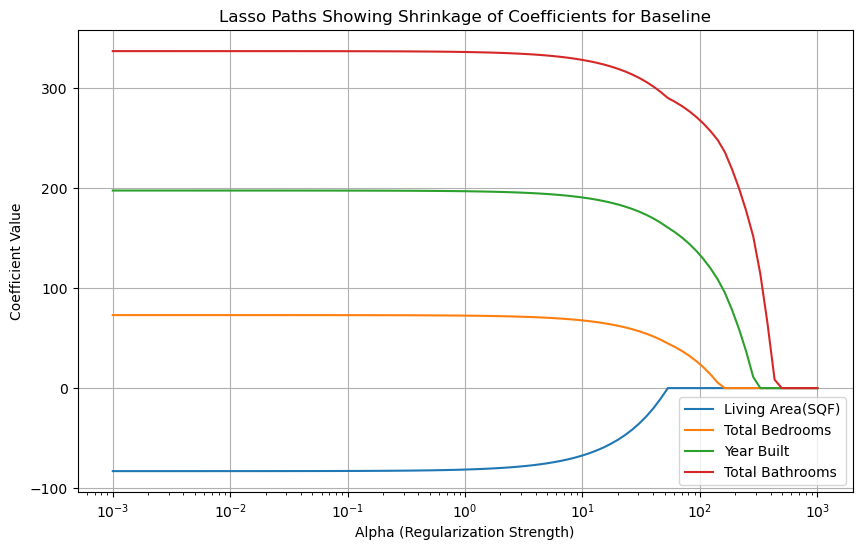

In [87]:
# Define the range of alpha values (regularization strength)
alphas = np.logspace(-3, 3, 100)  # Try values from 0.001 to 100 on a log scale

# Scale the features if needed
scaler = StandardScaler()
X_scaled = transformed_df_b

# Initialize an empty array to store coefficients
coefs = []

# For each alpha, fit Lasso and store the coefficients
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_scaled, y)
    coefs.append(lasso.coef_)

# Convert coefficients list to a numpy array for plotting
coefs = np.array(coefs)

# Plot the regularization path
plt.figure(figsize=(10, 6))

# Plot each feature’s coefficient path
for i, feature in enumerate(['Living Area(SQF)','Total Bedrooms', 'Year Built', 'Total Bathrooms']):
    plt.plot(alphas, coefs[:, i], label=feature)

# Set up plot details
plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("Coefficient Value")
plt.title("Lasso Paths Showing Shrinkage of Coefficients for Baseline")
plt.legend()
plt.xscale("log")  # Use a log scale for alpha
plt.grid(True)
#Save graph (folder_path + file_name)
plt.savefig("./Graphs/" + 'baseline_lasso_regularization.png')
plt.show()